# Import

In [1]:
import matplotlib.ticker as plticker
import cv2
import pytesseract
from PIL import Image
import PIL
from pdf2image import convert_from_path
import os
import numpy as np
import pandas as pd
from dbr import DynamsoftBarcodeReader
from matplotlib import pyplot as plt
from skimage.measure import compare_ssim
import imutils
import statistics
from scipy import stats
import random
from difflib import SequenceMatcher
from IPython.display import display, Markdown, Latex
import shutil
from google.cloud import vision
import io
%matplotlib inline
from google.oauth2 import service_account
#global 

# Convert PDF 2 IMAGE

In [2]:
def convert_pdf_2_image(uploaded_image_path, uploaded_image,img_size):
    project_dir = os.getcwd()
    os.chdir(uploaded_image_path)
    file_name = str(uploaded_image).replace('.pdf','')
    output_file = file_name+'.jpg'
    pages = convert_from_path(uploaded_image, 200,poppler_path='/Users/kunal/Documents/VdartWorking/Poppler/poppler-0.68.0_x86/poppler-0.68.0/bin/')
    for page in pages:
        page.save(output_file, 'JPEG')
        break
    os.chdir(project_dir)
    img = Image.open(output_file)
    img = img.resize(img_size, PIL.Image.ANTIALIAS)
    img.save(output_file)
    return output_file

# Small Basic Functions

In [3]:
def checkEqual1(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == rest for rest in iterator)
def getText(result, partText,text):
    endindex = result + 80
    partialdetected = text[result:endindex]
    endindex = partialdetected.find("\n")
    fulldetected = partialdetected[:endindex]
    startindex = fulldetected.find(partText)#'er'
    barcodeNumberdetectedname = fulldetected[startindex+3:28]
    return barcodeNumberdetectedname
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# BARCODE

In [4]:
def barcodefromTextDecoded(imgPath):
    """Detects document features in an image."""
    keyDIR = "/Users/kunal/Documents/VdartWorking/GOOGLEAPI/vdartrealfakevision-0f30bdc03946.json"
    credentials = service_account.Credentials.from_service_account_file(keyDIR)
    client = vision.ImageAnnotatorClient(credentials=credentials)

    # [START vision_python_migration_document_text_detection]
    with io.open(imgPath, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)

    response = client.document_text_detection(image=image)
    textDocument = []
    blockConfid = []
    paraConfid = []
    wordConfid = []
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    textDocument.append(word_text)
                    blockConfid.append(block.confidence)
                    paraConfid.append(paragraph.confidence)
                    wordConfid.append(word.confidence)
                    #if word_text == "Receipt" or word_text == "Number":
                        #print('\nBlock confidence: {}'.format(block.confidence))
                        #print('Paragraph confidence: {}'.format(paragraph.confidence))
                        #print('Word text: {} (confidence: {})'.format(word_text, word.confidence))
                        #print('\n')

                    #bit = word.symbols
                    #print(bit)
                    #for i in bit:
                        #print(i)

                    #for symbol in word.symbols:
                        #print('\tSymbol: {} (confidence: {})'.format(symbol.text, symbol.confidence))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    # [END vision_python_migration_document_text_detection]
    # [END vision_fulltext_detection]
    finalOutputArray = []
    count = 0
    for i in textDocument:
        if i == "Receipt":
            #print(i)
            #print(stringTotal[count+2])  
            #print(blockConfid[count+2])
            #print(paraConfid[count+2])
            #print(wordConfid[count+2])
            miniArray = [textDocument[count+2], blockConfid[count+2], paraConfid[count+2], wordConfid[count+2]]
            finalOutputArray.append(miniArray)
        count+=1
    return finalOutputArray

# Barcode PT 2

In [5]:
def barcodeDetectionDecoding(MAINPDFFILE, MAINIMAGEFILEPNG):
    barcodeArray = []
    dbr = DynamsoftBarcodeReader()
    dbr.initLicense('t0068MgAAAKRrPFRco9JDd3LAqC/rxW8uc9WY78TcwhKHwZLx6gk6QEs4fVW5LejQYwCeHQwN0OHv3IaI5ENqLbmYKUpP0/o=') # https://www.dynamsoft.com/CustomerPortal/Portal/Triallicense.aspx
    try:
        results = dbr.DecodeFile(MAINPDFFILE)
        textResults = results["TextResults"]
        for textResult in textResults:
            #print(textResult["BarcodeText"])
            barcodeArray.append(textResult["BarcodeText"])
    except TypeError as e:
        barcodeArray = [] 
    barcodeDetected = ""
    #print(barcodeArray)
    if len(barcodeArray) == 0:
        #print("NO BARCODE DETECTED!!!!")
        barcodeDetected = "N/A"
    elif len(barcodeArray) == 1:
        barcodeDetected = barcodeArray[0]
    elif len(barcodeArray) == 2:
        if similar(barcodeArray[0], barcodeArray[1]) > 0.9:
            barcodeDetected = barcodeArray[0]
    else:
        barcodeDetected = "N/A"
    barcodefromText = barcodefromTextDecoded(MAINIMAGEFILEPNG)
    equal = False
    if len(barcodefromText) == 3:
        result1 = barcodefromText[0][0]
        result2 = barcodefromText[1][0]
        result3 = barcodefromText[2][0]
        if result1 == result2 == result3:
            if barcodeDetected == result1:
                #Everything same
                #print("Same")
                equal = True
            elif len(result1) == len(barcodeDetected):
                #Same Length but different characters
                if similar(result1, barcodeDetected) > 0.9:
                    #print("Estimate that it is same for the most part")
                    equal = True
            elif abs(len(result1) - len(barcodeDetected)) > 3:
                #Barcoder is not fully detected
                equal = False
        elif ((result1 == result2 and similar(result3, result2)>0.9) or 
              (result1 == result3 and similar(result2, result1)>0.9) or 
              (result3 == result2 and similar(result1, result2)>0.9)):
            if (result1 == barcodeDetected or result2 == barcodeDetected or result3 == barcodeDetected):
                equal = True 
        elif (result1 != result2 != result3):
            equal = False
        else:
            equal = False
        BARCODEISCORRECT = equal
        result1final = result1
        result2final = result2
    if len(barcodefromText) == 2:
        result1 = barcodefromText[0][0]
        result2 = barcodefromText[1][0]
        if result1 == result2:
            if barcodeDetected == result1:
                #Everything same
                #print("Same")
                equal = True
            elif len(result1) == len(barcodeDetected):
                #Same Length but different characters
                if similar(result1, barcodeDetected) > 0.9:
                    #print("Estimate that it is same for the most part")
                    equal = True
            elif abs(len(result1) - len(barcodeDetected)) > 3:
                #Barcoder is not fully detected
                equal = False
        elif (similar(result1, result2)>0.9):
            if (result1 == barcodeDetected or result2 == barcodeDetected):
                equal = True 
        elif (result1 != result2):
            equal = False
        else:
            equal = False
        BARCODEISCORRECT = equal
        result1final = result1
        result2final = result2
    if len(barcodefromText) == 1:
        result1 = barcodefromText[0][0]
        if barcodeDetected == result1:
            equal = True
        elif len(result1) == len(barcodeDetected):
            #Same Length but different characters
            if similar(result1, barcodeDetected) > 0.9:
                #print("Estimate that it is same for the most part")
                equal = True
        elif abs(len(result1) - len(barcodeDetected)) > 3:
            #Barcoder is not fully detected
            equal = False
        else:
            equal = False
        BARCODEISCORRECT = equal
        result1final = result1
        result2final = ""
    return barcodeDetected, BARCODEISCORRECT, result1final, result2final

# DATE

In [6]:
def dateDetection(MAINIMAGEFILEPNG):
    keyDIR = "/Users/kunal/Documents/VdartWorking/GOOGLEAPI/vdartrealfakevision-0f30bdc03946.json"
    credentials = service_account.Credentials.from_service_account_file(keyDIR)
    client = vision.ImageAnnotatorClient(credentials=credentials)

    with io.open(MAINIMAGEFILEPNG, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)
    response = client.document_text_detection(image=image)
    textDocument = []
    blockConfid = []
    paraConfid = []
    wordConfid = []
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    textDocument.append(word_text)
                    blockConfid.append(block.confidence)
                    paraConfid.append(paragraph.confidence)
                    wordConfid.append(word.confidence)

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    finalOutputArray = []
    count = 0
    for i in textDocument:
        if i == "Valid":
            for i in range(13):
                finalOutputArray.append(textDocument[count+i])
        count+=1
    finalOutputArray.pop(0)
    finalOutputArray.pop(0)
    startArray = finalOutputArray[:5]
    endArray = finalOutputArray[6:]
    count = 0
    for i in startArray:
        if i == "/":
            startArray.pop(count)
        count+=1
    count = 0
    for i in endArray:
        if i == "/":
            endArray.pop(count)
        count+=1
    start = startArray
    end = endArray
    work = False
    reason = ""
    if ((len(start) == 3) and (len(end) == 3)):    
        if(start[2] > end[2]):
            work = False
            reason = "Year is before the starting one"
        if(start[2] == end[2]):
            if(end[0] < start[0]):
                work = False
                reason = "Month Doesn't Work"
            if(end[0] > start[0]):
                work = True
                reason = "Month Works"
            if(end[0] == start[0]):
                if(end[1] < start[1]):
                    work = False
                    reason = "Day Doesn't Work"
                if(end[1] > start[1]):
                    work = True
                    reason = "Day Works"
                if(end[1] == start[1]):
                    work = False
                    reason = "Date Same"
        if(start[2] < end[2]):
            work = True
            reason = "Year Works"
        try: 
            if(int(start[1]) > 31 or int(end[1]) > 31 or int(start[0]) > 12 or int(end[0]) > 12):
                work = False
                reason = "Date out of bounds"
        except ValueError as e:
            print(e)
    else:
        work = False
        reason = "The array is wrong"

    DATEWORKING = work
    WHYDATEISWORKING = reason
    return (DATEWORKING, WHYDATEISWORKING)

# TITLE COMPARE

In [7]:
def titleCOMPARE(CLEANARRAYFORMAINIMAGEFILEPNG, CLEANARRAYFORCOMPAREIMAGEFILEPNG):
    titleimgCV = CLEANARRAYFORMAINIMAGEFILEPNG[0:50, 10:650]
    titleimgCV2= CLEANARRAYFORCOMPAREIMAGEFILEPNG[0:50, 10:650]
    original = titleimgCV2 #know real
    duplicate = titleimgCV #dont know
    threshold = 50
    TITLEIMAGECOMPARE = False
    if original.shape == duplicate.shape:
        difference = cv2.subtract(original, duplicate)
        b, g, r = cv2.split(difference)
    x,y = b.shape
    size = x*y
    countb = 0
    countg = 0
    countr = 0
    countb11 = 0
    countg11 = 0
    countr11 = 0
    countb22 = 0
    countg22 = 0
    countr22 = 0
    for startthing1 in b:
        for endthomg1 in startthing1:
            if endthomg1 > 80:
                countb11+=1
            if endthomg1 > 50:
                countb+=1
            if endthomg1 > 30:
                countb22+=1
    for startthing2 in g:
        for endthomg2 in startthing2:
            if endthomg2 > 80:
                countg11+=1
            if endthomg2 > 50:
                countg+=1
            if endthomg2 > 30:
                countg22+=1    

    for startthing3 in r:
        for endthomg3 in startthing3:
            if endthomg3 > 80:
                countr11+=1
            if endthomg3 > 50:
                countr+=1
            if endthomg3 > 30:
                countr22+=1   
    PERCENT_BLUE_DIFFERENCE_TITLE = countb/size*100
    PERCENT_GREEN_DIFFERENCE_TITLE = countg/size*100
    PERCENT_RED_DIFFERENCE_TITLE = countr/size*100
    PERCENT_BLUE_DIFFERENCE_TITLE11 = countb11/size*100
    PERCENT_GREEN_DIFFERENCE_TITLE11 = countg11/size*100
    PERCENT_RED_DIFFERENCE_TITLE11 = countr11/size*100
    PERCENT_BLUE_DIFFERENCE_TITLE22 = countb22/size*100
    PERCENT_GREEN_DIFFERENCE_TITLE22 = countg22/size*100
    PERCENT_RED_DIFFERENCE_TITLE22 = countr22/size*100
    
    if PERCENT_BLUE_DIFFERENCE_TITLE < 15 and PERCENT_GREEN_DIFFERENCE_TITLE < 15 and PERCENT_RED_DIFFERENCE_TITLE < 15:
        TITLEIMAGECOMPARE = True
    return (PERCENT_BLUE_DIFFERENCE_TITLE, PERCENT_GREEN_DIFFERENCE_TITLE, PERCENT_RED_DIFFERENCE_TITLE,
            PERCENT_BLUE_DIFFERENCE_TITLE11, PERCENT_GREEN_DIFFERENCE_TITLE11, PERCENT_RED_DIFFERENCE_TITLE11,
            PERCENT_BLUE_DIFFERENCE_TITLE22, PERCENT_GREEN_DIFFERENCE_TITLE22, PERCENT_RED_DIFFERENCE_TITLE22, 
            TITLEIMAGECOMPARE)

# TEXT COMPRE

In [8]:
def textCOMPARE(MAINIMAGEFILEPNG, COMPAREIMAGEFILEPNG):
    keyDIR = "/Users/kunal/Documents/VdartWorking/GOOGLEAPI/vdartrealfakevision-0f30bdc03946.json"
    credentials = service_account.Credentials.from_service_account_file(keyDIR)
    client = vision.ImageAnnotatorClient(credentials=credentials)
    with io.open(MAINIMAGEFILEPNG, 'rb') as image_file:
        content = image_file.read()
    image = vision.types.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations
    totalString = ''
    for text in texts:
        totalString+=text.description
    totalString = totalString.rsplit(' ', 1)[0]

    credentials = service_account.Credentials.from_service_account_file(keyDIR)
    client = vision.ImageAnnotatorClient(credentials=credentials)
    with io.open(COMPAREIMAGEFILEPNG, 'rb') as image_file:
        content = image_file.read()
    image = vision.types.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations
    totalString2 = ''
    for text in texts:
        totalString2+=text.description
    totalString2 = totalString2.rsplit(' ', 1)[0]
    text = totalString
    text2 = totalString2
    yes = 0
    no = 0
    totoal = 0
    for i in range(100):
        startingValueofSTring = random.randint(1,len(text2))
        lengthofString = random.randint(3,10)
        small_string = text2[startingValueofSTring:startingValueofSTring+lengthofString]
        has_small_string = False
        if small_string in text:
            has_small_string = True
        if has_small_string:
            yes+=1
        else:
            no+=1
        totoal+=1
    diffsimiliar = yes/totoal
    diffdifferent = no/totoal
    similiar = similar(text, text2)
    if (similiar < 0.35):
        SIMILARTYBETWEENTEXTINDOCUMENT = False
    else:
        SIMILARTYBETWEENTEXTINDOCUMENT = True
    return SIMILARTYBETWEENTEXTINDOCUMENT, similiar, diffsimiliar, diffdifferent

# WaterMark 1

In [9]:
def waterMark1(CLEANARRAYFORMAINIMAGEFILEPNG, CLEANARRAYFORCOMPAREIMAGEFILEPNG):
    down2 = 239
    up2 = 248 
    array = CLEANARRAYFORMAINIMAGEFILEPNG
    arrayNew = CLEANARRAYFORMAINIMAGEFILEPNG
    w, h, j = array.shape
    array2 = CLEANARRAYFORCOMPAREIMAGEFILEPNG
    arrayNew2 = CLEANARRAYFORCOMPAREIMAGEFILEPNG
    w2, h2, j2 = array2.shape
    falsepixel = 0
    correctpixel = 0
    totalpixel = 0
    for x2 in range(w2-1):
        for y2 in range(h2-1):
            singlearray2 = array2[x2, y2]
            r2 = singlearray2[0]
            g2 = singlearray2[1]
            b2 = singlearray2[2]
            if (r2 > down2 and r2 < up2 and g2 > down2 and g2 < up2 and b2 > down2 and b2 < up2):
                arrayNew2[x2, y2] = [0, 255, 0]
                singlearray = array[x2,y2]
                r = singlearray[0]
                g = singlearray[1]
                b = singlearray[2]
                if (r > down2 and r < up2 and g > down2 and g < up2 and b > down2 and b < up2):
                    correctpixel +=1
                elif (r == 0 and g == 0 and b == 0):
                    falsepixel+=1
                totalpixel+=1
            else:
                arrayNew2[x2, y2] = [0, 0, 0]
    img2final = Image.fromarray(arrayNew2)
    im1 = img2final.save("REALImageWaterMark.jpg")
    return (correctpixel, falsepixel, totalpixel)

# WaterMark2

In [10]:
def WaterMark2(CLEANARRAYFORMAINIMAGEFILEPNG, CLEANARRAYFORCOMPAREIMAGEFILEPNG):
    down = 239#238 ----- 239 
    up = 248 # ---------248
    array = CLEANARRAYFORMAINIMAGEFILEPNG
    array2 = CLEANARRAYFORCOMPAREIMAGEFILEPNG
    arrayNew = CLEANARRAYFORMAINIMAGEFILEPNG
    arrayNew2 = CLEANARRAYFORCOMPAREIMAGEFILEPNG
    w,h,c = array.shape
    w2,h2,c2 = array2.shape
    NUMOFPIXELSHOULDTHEREBUTNOT = 0
    NUMOFPIXELNOTBUTTHERE = 0
    NUMOFCORRECTPIXEL = 0
    totalCOUNT = 0
    for x in range(w-1):
        for y in range(h-1):
            singlearray = array[x, y]
            r = singlearray[0]
            g = singlearray[1]
            b = singlearray[2]
            if (r > down and r < up and g > down and g < up and b > down and b < up):
                definitivVALUE = True
                totalCOUNT+=1
                arrayNew[x, y] = [0, 255, 0]
            else:
                definitivVALUE = False
                arrayNew[x, y] = [0, 0, 0]
            singlearray2 = array2[x, y]
            r2 = singlearray2[0]
            g2 = singlearray2[1]
            b2 = singlearray2[2]
            if (r2 > down and r2 < up and g2 > down and g2 < up and b2 > down and b2 < up):
                pixelDONTKNOW = True
            else:
                pixelDONTKNOW = False
            if(definitivVALUE and pixelDONTKNOW):
                #WHEN PIXEL SHOULD BE IN RANGE AND IS IN RANGE
                NUMOFCORRECTPIXEL+=1
            elif(definitivVALUE and not pixelDONTKNOW):
                #WHEN PIXEL SHOULD BE IN RANGE BUT ISNT
                NUMOFPIXELSHOULDTHEREBUTNOT+=1
            elif(not definitivVALUE and definitivVALUE):
                #WHEN PIXEL SHOULDN'T BE IN RANGE BUT IS
                NUMOFPIXELNOTBUTTHERE+=1      
    img = Image.fromarray(arrayNew)
    file1 = 'REALImageWaterMark.jpg'
    return array2, file1, NUMOFPIXELSHOULDTHEREBUTNOT, NUMOFPIXELNOTBUTTHERE, NUMOFCORRECTPIXEL, totalCOUNT
    

# WaterMark Average

In [11]:
def WaterMarkAverage(file1, array2):
    down = 239#238 ----- 239 
    up = 248
    row = []
    column = []
    array = cv2.imread(file1)
    x_length = len(array[0])
    y_length = len(array)
    for i in range(x_length):
        row.append(str(i))
    for i in range(y_length):
        column.append(str(i))
    df = pd.DataFrame(index=row, columns=column)
    array = cv2.imread(file1)
    arrayNew = cv2.imread(file1)
    NUMOFPIXELSHOULDTHEREBUTNOTAVERAGE = 0
    NUMOFPIXELNOTBUTTHEREAVERAGE = 0
    NUMOFCORRECTPIXELAVERAGE = 0
    totalCOUNTAVERAGE = 0
    definitivVALUEAVERAGE = False
    distance = 3
    dis = distance
    for thingthing in range(len(array[0])-distance):
        for thingthingYY in range(len(array)-distance):
            center_XXX = thingthing
            center_YYY = thingthingYY
            distance = dis
            partArrDis = [[0 for x in range(distance*2+1)] for y in range(distance*2+1)]
            center_XX = center_XXX
            center_YY = center_YYY
            for uu in range(distance*2+1):
                for rr in range(distance*2+1):
                    a,b,c = array[uu+(thingthingYY-distance*2+1)][rr+(thingthing-distance*2+1)]
                    theSingleArrayABC = [a,b,c]
                    partArrDis[uu][rr] = theSingleArrayABC
            countGreen = 0
            countBlack = 0
            totalCount = 0
            theXofARRRAY = len(partArrDis)
            theYofARRRAY = len(partArrDis[0])
            for aa in range(theXofARRRAY):
                for bb in range(theYofARRRAY):
                    singleARRAYwPART = partArrDis[aa][bb]
                    rr, gg, bb = singleARRAYwPART
                    if rr < 30 and gg < 30 and bb < 30:
                        countBlack += 1
                    else:
                        countGreen += 1    
                    totalCount+=1
            perceBlack = (countBlack/totalCount) * 100
            perceGreen = (countGreen/totalCount) * 100
            x = perceBlack+perceGreen
            IDK_X = center_XXX-distance*2+1
            IDK_Y = center_YYY-distance*2+1
            if (perceBlack > 60):
                arrayNew[IDK_Y][IDK_X]=[0,0,0]
                definitivVALUEAVERAGE = False
            else:
                arrayNew[IDK_Y][IDK_X] = [0,255,0]
                definitivVALUEAVERAGE = True
            singlearray2 = array2[thingthingYY, thingthing]
            r2 = singlearray2[0]
            g2 = singlearray2[1]
            b2 = singlearray2[2]
            if (r2 > down and r2 < up and g2 > down and g2 < up and b2 > down and b2 < up):
                pixelDONTKNOWAVERAGE = True
            else:
                pixelDONTKNOWAVERAGE = False
            if(definitivVALUEAVERAGE and pixelDONTKNOWAVERAGE):
                #WHEN PIXEL SHOULD BE IN RANGE AND IS IN RANGE
                NUMOFCORRECTPIXELAVERAGE+=1
            elif(definitivVALUEAVERAGE and not pixelDONTKNOWAVERAGE):
                #WHEN PIXEL SHOULD BE IN RANGE BUT ISNT
                NUMOFPIXELSHOULDTHEREBUTNOTAVERAGE+=1
            elif(not definitivVALUEAVERAGE and definitivVALUEAVERAGE):
                #WHEN PIXEL SHOULDN'T BE IN RANGE BUT IS
                NUMOFPIXELNOTBUTTHEREAVERAGE+=1     
            totalCOUNTAVERAGE+=1
    img = Image.fromarray(arrayNew)
    im1 = img.save("GroupedPixeledIMAGE.jpg")
    return NUMOFCORRECTPIXELAVERAGE, NUMOFPIXELSHOULDTHEREBUTNOTAVERAGE, NUMOFPIXELNOTBUTTHEREAVERAGE, totalCOUNTAVERAGE

# Per Diff

In [12]:
def perdifference(CLEANARRAYFORMAINIMAGEFILEPNG, CLEANARRAYFORCOMPAREIMAGEFILEPNG):    
    img1 = CLEANARRAYFORMAINIMAGEFILEPNG
    img2 = CLEANARRAYFORCOMPAREIMAGEFILEPNG
    imageA = CLEANARRAYFORMAINIMAGEFILEPNG
    imageB = CLEANARRAYFORCOMPAREIMAGEFILEPNG
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    bigH, bigW,other = imageA.shape
    (score, diff) = compare_ssim(grayA, grayB, full=True)
    diff = (diff * 255).astype('uint8')
    thresh = cv2.threshold(diff, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    areaDIFFERENCE = 0
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(imageA, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.rectangle(imageB, (x, y), (x + w, y + h), (0, 0, 255), 2)
        areaDIFFERENCE += (w*h)
    perdiff =  ((areaDIFFERENCE/(bigW*bigH))*100)
    
    
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    NUMBER_OF_KEYPOINST_IMG1 = len(keypoints_1)
    NUMBER_OF_KEYPOINST_IMG2 = len(keypoints_2)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1,descriptors_2)
    matches = sorted(matches, key = lambda x:x.distance)
    totalMATCHES = (len(matches))
    if img1 is None or img2 is None:
        exit(0)
    minHessian = 400
    detector = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    keypoints1, descriptors1 = detector.detectAndCompute(img1, None)
    keypoints2, descriptors2 = detector.detectAndCompute(img2, None)
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    knn_matches = matcher.knnMatch(descriptors1, descriptors2, 2)
    ratio_thresh1 = 0.6
    good_matches1 = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh1 * n.distance:
            good_matches1.append(m)
    ratio_thresh2 = 0.65
    good_matches2 = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh2 * n.distance:
            good_matches2.append(m) 
    ratio_thresh3 = 0.7
    good_matches3 = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh3 * n.distance:
            good_matches3.append(m)
    NUMEBROFMATCHESRATIOTESTFOR06 = len(good_matches1)
    NUMEBROFMATCHESRATIOTESTFOR065 = len(good_matches2)
    NUMEBROFMATCHESRATIOTESTFOR07 = len(good_matches3)
    img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
    img3 = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches2, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    im = Image.fromarray(img3)
    im.save('FINALWORKINGIMAGEPT1.png')
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    good1 = []
    for m,n in matches:
        if m.distance < 80:
            good1.append([m])
        if n.distance < 80:
            good1.append([n])
    good2 = []
    for m,n in matches:
        if m.distance < 85:
            good2.append([m])
        if n.distance < 85:
            good2.append([n])
    good3 = []
    for m,n in matches:
        if m.distance < 90:
            good3.append([m])
        if n.distance < 90:
            good3.append([n])         
    NUMEBROFMATCHESDISTANCETESTFOR80 = len(good1)
    NUMEBROFMATCHESDISTANCETESTFOR85 = len(good2)
    NUMEBROFMATCHESDISTANCETESTFOR90 = len(good3)
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good2,None,flags =2)
    im = Image.fromarray(img3)
    im.save('FINALWORKINGIMAGEPT2.png')
    return (score,
            perdiff, 
            NUMBER_OF_KEYPOINST_IMG1, NUMBER_OF_KEYPOINST_IMG2, # number 1 is unknow image
            totalMATCHES,
            NUMEBROFMATCHESRATIOTESTFOR06, NUMEBROFMATCHESRATIOTESTFOR065, NUMEBROFMATCHESRATIOTESTFOR07,
            NUMEBROFMATCHESDISTANCETESTFOR80, NUMEBROFMATCHESDISTANCETESTFOR85, NUMEBROFMATCHESDISTANCETESTFOR90)

# labelDetect

In [13]:
def labelDetect(MAINIMAGEFILEPNG):
    with io.open(MAINIMAGEFILEPNG, 'rb') as image_file:
        content = image_file.read()
    keyDIR = "/Users/kunal/Documents/VdartWorking/GOOGLEAPI/vdartrealfakevision-0f30bdc03946.json"
    credentials = service_account.Credentials.from_service_account_file(keyDIR)
    client = vision.ImageAnnotatorClient(credentials=credentials)
    image = vision.types.Image(content=content)
    response = client.label_detection(image=image)
    LabelDetectionArray = []
    for label in response.label_annotations:
        textandConfArray = []
        textandConfArray.append(label.description)
        textandConfArray.append(label.score*100)
        LabelDetectionArray.append(textandConfArray)
    real = 0
    fake = 0
    for i in range(len(LabelDetectionArray)):
        name = LabelDetectionArray[i][0]
        confid = LabelDetectionArray[i][1]
        if name == "Text":
            if confid > 95:
                real+=1
            else:
                fake+=1
        if name == "Font":
            if confid > 73:
                real+=1
            else:
                fake+=1 
        if name == "Font":
            if confid > 70:
                real+=1
            else:
                fake+=1 
        if name == "Font":
            if confid > 70:
                real+=1
            else:
                fake+=1
    LLabel1 = ""
    LConfid1 = 0
    LLabel2 = ""
    LConfid2 = 0
    LLabel3 = ""
    LConfid3 = 0
    
    if len(LabelDetectionArray) == 0:
        LLabel1 = ""
        LConfid1 = 0
        LLabel2 = ""
        LConfid2 = 0
        LLabel3 = ""
        LConfid3 = 0
    elif len(LabelDetectionArray) == 1:
        LLabel1 = LabelDetectionArray[0][0]
        LConfid1 = LabelDetectionArray[0][1] 
        LLabel2 = ""
        LConfid2 = 0
        LLabel3 = ""
        LConfid3 = 0
    elif len(LabelDetectionArray) == 2:
        LLabel1 = LabelDetectionArray[0][0]
        LConfid1 = LabelDetectionArray[0][1] 
        LLabel2 = LabelDetectionArray[1][0]
        LConfid2 = LabelDetectionArray[1][1]
        LLabel3 = ""
        LConfid3 = 0
    elif len(LabelDetectionArray) >= 3:
        LLabel1 = LabelDetectionArray[0][0]
        LConfid1 = LabelDetectionArray[0][1] 
        LLabel2 = LabelDetectionArray[1][0]
        LConfid2 = LabelDetectionArray[1][1]
        LLabel3 = LabelDetectionArray[2][0]
        LConfid3 = LabelDetectionArray[2][1]
    else: 
        print("Something wrong with Label")
        
    return (LLabel1, LConfid1, LLabel2, LConfid2, LLabel3, LConfid3)

In [14]:
PERCENT_BLUE_DIFFERENCE_TITLE = 10
print(PERCENT_BLUE_DIFFERENCE_TITLE < 28.5)

True


# REAL FAKE

In [15]:
def realfake(testingPNG, testingPDF, realPNG):
    
    MAINIMAGEFILEPNG = testingPNG
    MAINPDFFILE = testingPDF
    CLEANARRAYFORMAINIMAGEFILEPNG = cv2.imread(MAINIMAGEFILEPNG)
    x11, y11, z11 = CLEANARRAYFORMAINIMAGEFILEPNG.shape
    CLEANARRAYFORMAINIMAGEFILEPNG = cv2.resize(CLEANARRAYFORMAINIMAGEFILEPNG, dsize=(698, 910), interpolation=cv2.INTER_CUBIC)
    COMPAREIMAGEFILEPNG = realPNG
    CLEANARRAYFORCOMPAREIMAGEFILEPNG = cv2.imread(COMPAREIMAGEFILEPNG) 
    x2, y2, z2 = CLEANARRAYFORCOMPAREIMAGEFILEPNG.shape
    CLEANARRAYFORCOMPAREIMAGEFILEPNG = cv2.resize(CLEANARRAYFORCOMPAREIMAGEFILEPNG, dsize=(698, 910), interpolation=cv2.INTER_CUBIC)
    imageCV = CLEANARRAYFORMAINIMAGEFILEPNG
    
    OCRPIC = MAINIMAGEFILEPNG
    value=Image.open(OCRPIC)
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"
    text = pytesseract.image_to_string(value, config='')
    
    
    countREAL = 0
    countFAKE = 0
    
    try:
        barcodeDetected, BARCODEISCORRECT, result1Final, result2Final = barcodeDetectionDecoding(MAINPDFFILE, MAINIMAGEFILEPNG)
    except UnboundLocalError as e:
        print(e)
    if BARCODEISCORRECT:
        countREAL += 1
    else:
        countFAKE += 1
    print("BARCODE: ", BARCODEISCORRECT)
    DATEWORKING,WHYDATEISWORKING = dateDetection(MAINIMAGEFILEPNG)
    if DATEWORKING:
        countREAL += 1
    else:
        countFAKE += 1
    print("Date Working: ", DATEWORKING)
    PERCENT_BLUE_DIFFERENCE_TITLE, PERCENT_GREEN_DIFFERENCE_TITLE, PERCENT_RED_DIFFERENCE_TITLE,PERCENT_BLUE_DIFFERENCE_TITLE11, PERCENT_GREEN_DIFFERENCE_TITLE11, PERCENT_RED_DIFFERENCE_TITLE11,PERCENT_BLUE_DIFFERENCE_TITLE22, PERCENT_GREEN_DIFFERENCE_TITLE22, PERCENT_RED_DIFFERENCE_TITLE22, TITLEIMAGECOMPARE = titleCOMPARE(CLEANARRAYFORMAINIMAGEFILEPNG, CLEANARRAYFORCOMPAREIMAGEFILEPNG)
    
    if PERCENT_BLUE_DIFFERENCE_TITLE < 28.5:
        countREAL+=1
    else:
        countFAKE+=1
    print("Blue Title 50: ", PERCENT_BLUE_DIFFERENCE_TITLE, "\t 28.5 \t ", PERCENT_BLUE_DIFFERENCE_TITLE < 28.5)
    if PERCENT_GREEN_DIFFERENCE_TITLE < 28:
        countREAL+=1
    else:
        countFAKE+=1
    print("Green Title 50: ", PERCENT_GREEN_DIFFERENCE_TITLE, "\t 28 \t ", PERCENT_BLUE_DIFFERENCE_TITLE < 28)
    if PERCENT_RED_DIFFERENCE_TITLE < 30:
        countREAL+=1
    else:
        countFAKE+=1 
    print("Red Title 50: ", PERCENT_RED_DIFFERENCE_TITLE, "\t 30 \t ", PERCENT_BLUE_DIFFERENCE_TITLE < 30)
    if PERCENT_BLUE_DIFFERENCE_TITLE11 < 20:
        countREAL+=1
    else:
        countFAKE+=1 
    print("Blue Title 80: ", PERCENT_BLUE_DIFFERENCE_TITLE11, "\t 20 \t ", PERCENT_BLUE_DIFFERENCE_TITLE < 20)
    if PERCENT_GREEN_DIFFERENCE_TITLE11 < 20:
        countREAL+=1
    else:
        countFAKE+=1 
    print("Green Title 80: ", PERCENT_GREEN_DIFFERENCE_TITLE11, "\t 20 \t ", PERCENT_BLUE_DIFFERENCE_TITLE < 20)
    if PERCENT_RED_DIFFERENCE_TITLE11 < 20.5:
        countREAL+=1
    else:
        countFAKE+=1 
    print("Red Title 80: ", PERCENT_RED_DIFFERENCE_TITLE11, "\t 20.5 \t ", PERCENT_BLUE_DIFFERENCE_TITLE < 20.5)
    if PERCENT_BLUE_DIFFERENCE_TITLE22 < 35.5:
        countREAL+=1
    else:
        countFAKE+=1 
    print("Blue Title 30: ", PERCENT_BLUE_DIFFERENCE_TITLE22, "\t 35.5 \t ", PERCENT_BLUE_DIFFERENCE_TITLE < 35.5)
    if PERCENT_GREEN_DIFFERENCE_TITLE22 < 34:
        countREAL+=1
    else:
        countFAKE+=1 
    print("Green Title 30: ", PERCENT_GREEN_DIFFERENCE_TITLE22, "\t 34 \t ", PERCENT_BLUE_DIFFERENCE_TITLE < 34)
    if PERCENT_RED_DIFFERENCE_TITLE22 < 37:
        countREAL+=1
    else:
        countFAKE+=1 
    print("Red Title 30: ", PERCENT_RED_DIFFERENCE_TITLE22, "\t 34 \t ", PERCENT_BLUE_DIFFERENCE_TITLE < 34)
    
    SIMILARTYBETWEENTEXTINDOCUMENT, similiar, diffsimiliar, diffdifferent = textCOMPARE(MAINIMAGEFILEPNG, COMPAREIMAGEFILEPNG)
    
    
    correctpixel, falsepixel, totalpixel = waterMark1(CLEANARRAYFORMAINIMAGEFILEPNG, CLEANARRAYFORCOMPAREIMAGEFILEPNG)
    
    
    array2, file1, NUMOFPIXELSHOULDTHEREBUTNOT, NUMOFPIXELNOTBUTTHERE, NUMOFCORRECTPIXEL, totalCOUNT = WaterMark2(CLEANARRAYFORMAINIMAGEFILEPNG, CLEANARRAYFORCOMPAREIMAGEFILEPNG)
    
                                                                                                          
    NUMOFCORRECTPIXELAVERAGE, NUMOFPIXELSHOULDTHEREBUTNOTAVERAGE, NUMOFPIXELNOTBUTTHEREAVERAGE, totalCOUNTAVERAGE = WaterMarkAverage(file1, array2)
    
        
    
    WATERMARKOUTPUTFINAL=False
    WATERMARKOUTPUTave=False
    WATERMARKOUTPUT2=False
    WATERMARKOUTPUTFINAL=False
    
    
    coorect = correctpixel/totalpixel*100
    worng = falsepixel/totalpixel*100
    
    if coorect > 5.5:
        countREAL+=1
    else:
        countFAKE+=1
        
    print("Watermark 1: ", coorect, "\t 5.5 \t ", coorect > 5.5)
    
    if worng > 0.15:
        countREAL+=1
    else:
        countFAKE+=1
    print("Watermark 1: ", worng, "\t 0.15 \t ", worng > 0.15)
    
    
    aveCorrect = NUMOFCORRECTPIXELAVERAGE/totalCOUNTAVERAGE *100
    aveWRONG = NUMOFPIXELSHOULDTHEREBUTNOTAVERAGE/totalCOUNTAVERAGE *100
    aveERROR = NUMOFPIXELNOTBUTTHEREAVERAGE
    
    
    correctPT2 = NUMOFCORRECTPIXEL/totalCOUNT *100
    wrongPT2= NUMOFPIXELSHOULDTHEREBUTNOT/totalCOUNT*100
    errorPT2 = NUMOFPIXELNOTBUTTHERE
    
    
    
    
    if coorect < 10:
        WATERMARKOUTPUT1 = False
    else:
        WATERMARKOUTPUT1 = True
    if aveCorrect < 10:
        WATERMARKOUTPUTave = False
    else:
        WATERMARKOUTPUTave = True
    if correctPT2 < 10:
        WATERMARKOUTPUT2 = False
    else:
        WATERMARKOUTPUT2 = True
    if WATERMARKOUTPUT1 == True and WATERMARKOUTPUTave == True and WATERMARKOUTPUT2 == True: 
        WATERMARKOUTPUTFINAL = True
    elif WATERMARKOUTPUT1 == True and WATERMARKOUTPUTave == True and WATERMARKOUTPUT2 == False: 
        WATERMARKOUTPUTFINAL = True
    elif WATERMARKOUTPUT1 == False and WATERMARKOUTPUTave == True and WATERMARKOUTPUT2 == True: 
        WATERMARKOUTPUTFINAL = True
    elif WATERMARKOUTPUT1 == True and WATERMARKOUTPUTave == False and WATERMARKOUTPUT2 == True: 
        WATERMARKOUTPUTFINAL = True
    
                                                                                                          
    score, perdiff, NUMBER_OF_KEYPOINST_IMG1, NUMBER_OF_KEYPOINST_IMG2, totalMATCHES, NUMEBROFMATCHESRATIOTESTFOR06, NUMEBROFMATCHESRATIOTESTFOR065, NUMEBROFMATCHESRATIOTESTFOR07, NUMEBROFMATCHESDISTANCETESTFOR80, NUMEBROFMATCHESDISTANCETESTFOR85, NUMEBROFMATCHESDISTANCETESTFOR90 = perdifference(CLEANARRAYFORMAINIMAGEFILEPNG, CLEANARRAYFORCOMPAREIMAGEFILEPNG)                                        
                                                                                                          
    
    if NUMBER_OF_KEYPOINST_IMG1 > 4800:
        countREAL+=1
    else:
        countFAKE+=1
    print("Keypoints 1: ", NUMBER_OF_KEYPOINST_IMG1, "\t 4800 \t ", NUMBER_OF_KEYPOINST_IMG1 > 4800)
    if totalMATCHES > 3000:
        countREAL+=1
    else:
        countFAKE+=1
    print("TotalMatches: ", totalMATCHES, "\t 3000 \t ", totalMATCHES > 3000)
    if NUMEBROFMATCHESRATIOTESTFOR07 > 48:
        countREAL+=1
    else:
        countFAKE+=1
    print("Matches Ratio 07: ", NUMEBROFMATCHESRATIOTESTFOR07, "\t 48 \t ",  NUMEBROFMATCHESRATIOTESTFOR07 > 48)   
        
    if NUMEBROFMATCHESDISTANCETESTFOR80 > 40:
        countREAL+=1
    else:
        countFAKE+=1
    print("Matches Ratio 80: ", NUMEBROFMATCHESDISTANCETESTFOR80, "\t 40 \t ",  NUMEBROFMATCHESDISTANCETESTFOR80 > 40)   
    
    if NUMEBROFMATCHESDISTANCETESTFOR85 > 44:
        countREAL+=1
    else:
        countFAKE+=1
    print("Matches Ratio 85: ", NUMEBROFMATCHESDISTANCETESTFOR85, "\t 44 \t ",  NUMEBROFMATCHESDISTANCETESTFOR85 > 44)   
    
    if NUMEBROFMATCHESDISTANCETESTFOR90 > 50:
        countREAL+=1
    else:
        countFAKE+=1
    print("Matches Distance 90: ", NUMEBROFMATCHESDISTANCETESTFOR90, "\t 50 \t ", NUMEBROFMATCHESDISTANCETESTFOR90 > 50)   
    
    
    
    LLabel1, LConfid1, LLabel2, LConfid2, LLabel3, LConfid3 = labelDetect(MAINIMAGEFILEPNG)

    totalCountREALFAKE = countFAKE + countREAL
    realFAKEDocument = countREAL/totalCountREALFAKE * 100
    documentanswer = False
    display(Markdown('**{}**'.format(realFAKEDocument)))
    if countREAL >= 70:
        documentanswer = True
    if documentanswer:
        display(Markdown('**Document is REAL**'))
    else:
        display(Markdown('**Document is FAKE**'))
    return (MAINIMAGEFILEPNG, MAINPDFFILE, COMPAREIMAGEFILEPNG, 
            result1Final, result2Final, barcodeDetected, 
            DATEWORKING, WHYDATEISWORKING,
            PERCENT_BLUE_DIFFERENCE_TITLE, PERCENT_GREEN_DIFFERENCE_TITLE, PERCENT_RED_DIFFERENCE_TITLE, #50
            PERCENT_BLUE_DIFFERENCE_TITLE11, PERCENT_GREEN_DIFFERENCE_TITLE11, PERCENT_RED_DIFFERENCE_TITLE11, #80
            PERCENT_BLUE_DIFFERENCE_TITLE22, PERCENT_GREEN_DIFFERENCE_TITLE22, PERCENT_RED_DIFFERENCE_TITLE22, #30
            TITLEIMAGECOMPARE,
            similiar, diffsimiliar, diffdifferent,
            coorect, worng,
            aveCorrect, aveWRONG, aveERROR,
            correctPT2,wrongPT2, errorPT2,
            WATERMARKOUTPUTFINAL,
            score,
            perdiff, 
            NUMBER_OF_KEYPOINST_IMG1, NUMBER_OF_KEYPOINST_IMG2, # number 1 is unknow image
            totalMATCHES,
            NUMEBROFMATCHESRATIOTESTFOR06, NUMEBROFMATCHESRATIOTESTFOR065, NUMEBROFMATCHESRATIOTESTFOR07,
            NUMEBROFMATCHESDISTANCETESTFOR80, NUMEBROFMATCHESDISTANCETESTFOR85, NUMEBROFMATCHESDISTANCETESTFOR90, 
            LLabel1, LConfid1, LLabel2, LConfid2, LLabel3, LConfid3, realFAKEDocument)#47

# Array Managment

In [16]:
def appendthefiles(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1):
    aARRAY.append(a)
    bARRAY.append(b)
    cARRAY.append(c)
    dARRAY.append(d)
    eARRAY.append(e)
    fARRAY.append(f)
    gARRAY.append(g)
    hARRAY.append(h)
    iARRAY.append(i)
    jARRAY.append(j)
    kARRAY.append(k)
    lARRAY.append(l)
    mARRAY.append(m)
    nARRAY.append(n)
    oARRAY.append(o)
    pARRAY.append(p)
    qARRAY.append(q)
    rARRAY.append(r)
    sARRAY.append(s)
    tARRAY.append(t)
    uARRAY.append(u)
    vARRAY.append(v)
    wARRAY.append(w)
    xARRAY.append(x)
    yARRAY.append(y)
    zARRAY.append(z)
    a1ARRAY.append(a1)
    b1ARRAY.append(b1)
    c1ARRAY.append(c1)
    d1ARRAY.append(d1)
    e1ARRAY.append(e1)
    f1ARRAY.append(f1)
    g1ARRAY.append(g1)
    h1ARRAY.append(h1)
    i1ARRAY.append(i1)
    j1ARRAY.append(j1)
    k1ARRAY.append(k1)
    l1ARRAY.append(l1)
    m1ARRAY.append(m1)
    n1ARRAY.append(n1)
    o1ARRAY.append(o1)
    p1ARRAY.append(p1)
    q1ARRAY.append(q1)
    r1ARRAY.append(r1)
    s1ARRAY.append(s1)
    t1ARRAY.append(t1)
    u1ARRAY.append(u1)
    v1ARRAY.append(v1)

In [17]:
aARRAY,bARRAY,cARRAY,dARRAY,eARRAY,fARRAY,gARRAY,hARRAY,iARRAY,jARRAY,kARRAY,lARRAY,mARRAY,nARRAY,oARRAY,pARRAY,qARRAY, rARRAY,sARRAY,tARRAY,uARRAY,vARRAY,wARRAY,xARRAY,yARRAY,zARRAY,a1ARRAY,b1ARRAY,c1ARRAY,d1ARRAY,e1ARRAY,f1ARRAY,g1ARRAY,h1ARRAY,i1ARRAY,j1ARRAY,k1ARRAY,l1ARRAY,m1ARRAY,n1ARRAY,o1ARRAY,p1ARRAY,q1ARRAY, r1ARRAY, s1ARRAY, t1ARRAY, u1ARRAY, v1ARRAY  = ([] for i in range(48))

In [18]:
#a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1 = realfake(pngFile, finalDir, FILEREAL)
    

# Actual Run

In [19]:
%%time
FILEREAL = '/Users/kunal/Documents/VdartWorking/realFake/Document.jpg'
print("a-t(1-20) is real and t-n1(21-40) is fake")

testingDIR = "/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/"
realDIR = "/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/Real/"
fakeDIR = "/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/Fake/"

os.chdir(testingDIR)
count = 0

for i in os.listdir(testingDIR):
    pathName = testingDIR + i.replace('.pdf', '')
    os.mkdir(pathName)
    shutil.move(i, pathName)
    finalDir = pathName + "/" + i
    PicForI = i
    finalDirPIC = pathName + "/" + PicForI.replace('.pdf', '.jpg')
    os.chdir(pathName)
    convert_pdf_2_image(pathName, i,(698,910))
    pngFile = finalDirPIC
    print(pngFile)
    print(finalDir)
    a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1 = realfake(pngFile, finalDir, FILEREAL)
    appendthefiles(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1)
    print("DONE")
    os.chdir(testingDIR)

a-t(1-20) is real and t-n1(21-40) is fake
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/a/a.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/a/a.pdf
BARCODE:  True
Date Working:  True
Blue Title 50:  17.853125 	 28.5 	  True
Green Title 50:  17.625 	 28 	  True
Red Title 50:  15.953125000000002 	 30 	  True
Blue Title 80:  11.79375 	 20 	  True
Green Title 80:  11.821875 	 20 	  True
Red Title 80:  9.40625 	 20.5 	  True
Blue Title 30:  22.237499999999997 	 35.5 	  True
Green Title 30:  21.85 	 34 	  True
Red Title 30:  20.878125 	 34 	  True
Watermark 1:  16.873289842163967 	 5.5 	  True
Watermark 1:  0.03851616475289473 	 0.15 	  False
Keypoints 1:  6382 	 4800 	  True
TotalMatches:  3954 	 3000 	  True
Matches Ratio 07:  59 	 48 	  True
Matches Ratio 80:  21 	 40 	  False
Matches Ratio 85:  24 	 44 	  False
Matches Distance 90:  29 	 50 	  False


**78.94736842105263**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/a1/a1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/a1/a1.pdf
BARCODE:  False
Date Working:  True
Blue Title 50:  15.153125000000001 	 28.5 	  True
Green Title 50:  19.418750000000003 	 28 	  True
Red Title 50:  20.746875 	 30 	  True
Blue Title 80:  8.328125 	 20 	  True
Green Title 80:  13.05 	 20 	  True
Red Title 80:  12.853125000000002 	 20.5 	  True
Blue Title 30:  19.834375 	 35.5 	  True
Green Title 30:  24.584375 	 34 	  True
Red Title 30:  26.7125 	 34 	  True
Watermark 1:  6.415348691654028 	 5.5 	  True
Watermark 1:  0.0 	 0.15 	  False
Keypoints 1:  1892 	 4800 	  False
TotalMatches:  1707 	 3000 	  False
Matches Ratio 07:  55 	 48 	  True
Matches Ratio 80:  88 	 40 	  True
Matches Ratio 85:  100 	 44 	  True
Matches Distance 90:  104 	 50 	  True


**78.94736842105263**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/b/b.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/b/b.pdf
BARCODE:  True
Date Working:  True
Blue Title 50:  18.0375 	 28.5 	  True
Green Title 50:  17.36875 	 28 	  True
Red Title 50:  20.78125 	 30 	  True
Blue Title 80:  11.975 	 20 	  True
Green Title 80:  11.590625000000001 	 20 	  True
Red Title 80:  13.640625 	 20.5 	  True
Blue Title 30:  23.193749999999998 	 35.5 	  True
Green Title 30:  22.23125 	 34 	  True
Red Title 30:  26.3625 	 34 	  True
Watermark 1:  3.771374465387609 	 5.5 	  False
Watermark 1:  0.33942370188488485 	 0.15 	  True
Keypoints 1:  2979 	 4800 	  False
TotalMatches:  2305 	 3000 	  False
Matches Ratio 07:  33 	 48 	  False
Matches Ratio 80:  25 	 40 	  False
Matches Ratio 85:  30 	 44 	  False
Matches Distance 90:  37 	 50 	  False


**63.1578947368421**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/b1/b1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/b1/b1.pdf
BARCODE:  False
Date Working:  True
Blue Title 50:  0.0 	 28.5 	  True
Green Title 50:  0.0 	 28 	  True
Red Title 50:  0.0 	 30 	  True
Blue Title 80:  0.0 	 20 	  True
Green Title 80:  0.0 	 20 	  True
Red Title 80:  0.0 	 20.5 	  True
Blue Title 30:  0.0 	 35.5 	  True
Green Title 30:  0.0 	 34 	  True
Red Title 30:  0.0 	 34 	  True
Watermark 1:  15.154505990066038 	 5.5 	  True
Watermark 1:  0.011233881386260964 	 0.15 	  False
Keypoints 1:  8747 	 4800 	  True
TotalMatches:  4652 	 3000 	  True
Matches Ratio 07:  74 	 48 	  True
Matches Ratio 80:  42 	 40 	  True
Matches Ratio 85:  57 	 44 	  True
Matches Distance 90:  70 	 50 	  True


**89.47368421052632**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/c/c.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/c/c.pdf
BARCODE:  True
Date Working:  True
Blue Title 50:  24.1125 	 28.5 	  True
Green Title 50:  23.396875 	 28 	  True
Red Title 50:  27.681250000000002 	 30 	  True
Blue Title 80:  16.121875 	 20 	  False
Green Title 80:  15.484375 	 20 	  False
Red Title 80:  18.496875 	 20.5 	  False
Blue Title 30:  29.521874999999998 	 35.5 	  True
Green Title 30:  28.50625 	 34 	  True
Red Title 30:  34.38125 	 34 	  True
Watermark 1:  47.63085465764746 	 5.5 	  True
Watermark 1:  0.0 	 0.15 	  False
Keypoints 1:  13117 	 4800 	  True
TotalMatches:  4801 	 3000 	  True
Matches Ratio 07:  41 	 48 	  False
Matches Ratio 80:  0 	 40 	  False
Matches Ratio 85:  0 	 44 	  False
Matches Distance 90:  0 	 50 	  False


**73.68421052631578**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/c1/c1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/c1/c1.pdf
BARCODE:  False
Date Working:  True
Blue Title 50:  31.271874999999998 	 28.5 	  False
Green Title 50:  30.659375 	 28 	  False
Red Title 50:  33.221875 	 30 	  False
Blue Title 80:  26.375 	 20 	  False
Green Title 80:  25.740625 	 20 	  False
Red Title 80:  28.6375 	 20.5 	  False
Blue Title 30:  34.1875 	 35.5 	  True
Green Title 30:  33.628125 	 34 	  True
Red Title 30:  36.153125 	 34 	  True
Watermark 1:  9.130738306733107 	 5.5 	  True
Watermark 1:  1.2028277284289417 	 0.15 	  True
Keypoints 1:  6469 	 4800 	  True
TotalMatches:  4198 	 3000 	  True
Matches Ratio 07:  58 	 48 	  True
Matches Ratio 80:  42 	 40 	  True
Matches Ratio 85:  47 	 44 	  True
Matches Distance 90:  51 	 50 	  True


**63.1578947368421**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/d/d.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/d/d.pdf
BARCODE:  True
Date Working:  True
Blue Title 50:  23.909375 	 28.5 	  True
Green Title 50:  23.271875 	 28 	  True
Red Title 50:  26.868750000000002 	 30 	  True
Blue Title 80:  17.846875 	 20 	  False
Green Title 80:  17.215625000000003 	 20 	  False
Red Title 80:  20.349999999999998 	 20.5 	  False
Blue Title 30:  28.249999999999996 	 35.5 	  True
Green Title 30:  27.409375000000004 	 34 	  True
Red Title 30:  31.078125 	 34 	  True
Watermark 1:  10.464360511302088 	 5.5 	  True
Watermark 1:  0.2615889522800767 	 0.15 	  True
Keypoints 1:  5271 	 4800 	  True
TotalMatches:  3179 	 3000 	  True
Matches Ratio 07:  36 	 48 	  False
Matches Ratio 80:  36 	 40 	  False
Matches Ratio 85:  44 	 44 	  False
Matches Distance 90:  45 	 50 	  False


**78.94736842105263**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/d1/d1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/d1/d1.pdf
BARCODE:  False
Date Working:  True
Blue Title 50:  23.290625000000002 	 28.5 	  True
Green Title 50:  23.1625 	 28 	  True
Red Title 50:  24.91875 	 30 	  True
Blue Title 80:  14.190625 	 20 	  False
Green Title 80:  14.546875 	 20 	  False
Red Title 80:  14.2375 	 20.5 	  False
Blue Title 30:  30.162499999999998 	 35.5 	  True
Green Title 30:  29.734375 	 34 	  True
Red Title 30:  33.053125 	 34 	  True
Watermark 1:  5.490158317485537 	 5.5 	  False
Watermark 1:  0.0008024200990186403 	 0.15 	  False
Keypoints 1:  3889 	 4800 	  False
TotalMatches:  2919 	 3000 	  False
Matches Ratio 07:  35 	 48 	  False
Matches Ratio 80:  22 	 40 	  False
Matches Ratio 85:  30 	 44 	  False
Matches Distance 90:  33 	 50 	  False


**52.63157894736842**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/e/e.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/e/e.pdf
BARCODE:  True
Date Working:  True
Blue Title 50:  21.059375 	 28.5 	  True
Green Title 50:  19.818749999999998 	 28 	  True
Red Title 50:  20.046875 	 30 	  True
Blue Title 80:  14.512500000000001 	 20 	  False
Green Title 80:  13.368749999999999 	 20 	  False
Red Title 80:  12.246875 	 20.5 	  False
Blue Title 30:  25.840625 	 35.5 	  True
Green Title 30:  24.528125 	 34 	  True
Red Title 30:  25.337500000000002 	 34 	  True
Watermark 1:  9.699654156937324 	 5.5 	  True
Watermark 1:  0.023270182871540566 	 0.15 	  False
Keypoints 1:  6190 	 4800 	  True
TotalMatches:  3683 	 3000 	  True
Matches Ratio 07:  44 	 48 	  False
Matches Ratio 80:  46 	 40 	  True
Matches Ratio 85:  52 	 44 	  True
Matches Distance 90:  58 	 50 	  True


**89.47368421052632**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/e1/e1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/e1/e1.pdf
BARCODE:  False
Date Working:  True
Blue Title 50:  35.2625 	 28.5 	  False
Green Title 50:  34.753125000000004 	 28 	  False
Red Title 50:  31.990625 	 30 	  False
Blue Title 80:  25.24375 	 20 	  False
Green Title 80:  25.35 	 20 	  False
Red Title 80:  20.815624999999997 	 20.5 	  False
Blue Title 30:  51.5875 	 35.5 	  True
Green Title 30:  43.996875 	 34 	  False
Red Title 30:  49.6375 	 34 	  False
Watermark 1:  0.03931858485191337 	 5.5 	  False
Watermark 1:  0.0 	 0.15 	  False
Keypoints 1:  651 	 4800 	  False
TotalMatches:  543 	 3000 	  False
Matches Ratio 07:  85 	 48 	  True
Matches Ratio 80:  67 	 40 	  True
Matches Ratio 85:  89 	 44 	  True
Matches Distance 90:  126 	 50 	  True


**26.31578947368421**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/f/f.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/f/f.pdf
BARCODE:  False
Date Working:  True
Blue Title 50:  30.599999999999998 	 28.5 	  False
Green Title 50:  31.3125 	 28 	  False
Red Title 50:  28.487499999999997 	 30 	  False
Blue Title 80:  23.0875 	 20 	  False
Green Title 80:  24.20625 	 20 	  False
Red Title 80:  20.4875 	 20.5 	  False
Blue Title 30:  36.259375 	 35.5 	  True
Green Title 30:  36.715625 	 34 	  True
Red Title 30:  34.0625 	 34 	  True
Watermark 1:  19.1778403665455 	 5.5 	  True
Watermark 1:  0.22708488802227517 	 0.15 	  True
Keypoints 1:  10722 	 4800 	  True
TotalMatches:  4694 	 3000 	  True
Matches Ratio 07:  39 	 48 	  False
Matches Ratio 80:  0 	 40 	  False
Matches Ratio 85:  1 	 44 	  False
Matches Distance 90:  1 	 50 	  False


**42.10526315789473**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/f1/f1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/f1/f1.pdf
BARCODE:  False
invalid literal for int() with base 10: ':'
Date Working:  True
Blue Title 50:  25.893749999999997 	 28.5 	  True
Green Title 50:  24.984375 	 28 	  True
Red Title 50:  27.431250000000002 	 30 	  True
Blue Title 80:  17.640625 	 20 	  False
Green Title 80:  17.146875 	 20 	  False
Red Title 80:  18.131249999999998 	 20.5 	  False
Blue Title 30:  31.303124999999998 	 35.5 	  True
Green Title 30:  30.128125 	 34 	  True
Red Title 30:  33.3375 	 34 	  True
Watermark 1:  27.904961363472232 	 5.5 	  True
Watermark 1:  0.20301228505171598 	 0.15 	  True
Keypoints 1:  12054 	 4800 	  True
TotalMatches:  4912 	 3000 	  True
Matches Ratio 07:  40 	 48 	  False
Matches Ratio 80:  0 	 40 	  False
Matches Ratio 85:  0 	 44 	  False
Matches Distance 90:  0 	 50 	  False


**73.68421052631578**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/g/g.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/g/g.pdf
BARCODE:  False
Date Working:  True
Blue Title 50:  34.009375 	 28.5 	  False
Green Title 50:  33.059375 	 28 	  False
Red Title 50:  33.0625 	 30 	  False
Blue Title 80:  23.071875 	 20 	  False
Green Title 80:  22.693749999999998 	 20 	  False
Red Title 80:  21.19375 	 20.5 	  False
Blue Title 30:  40.9125 	 35.5 	  True
Green Title 30:  39.65 	 34 	  False
Red Title 30:  40.699999999999996 	 34 	  False
Watermark 1:  2.1288205226964525 	 5.5 	  False
Watermark 1:  0.008024200990186402 	 0.15 	  False
Keypoints 1:  1276 	 4800 	  False
TotalMatches:  1176 	 3000 	  False
Matches Ratio 07:  50 	 48 	  True
Matches Ratio 80:  43 	 40 	  True
Matches Ratio 85:  48 	 44 	  True
Matches Distance 90:  55 	 50 	  True


**26.31578947368421**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/g1/g1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/g1/g1.pdf
BARCODE:  False
invalid literal for int() with base 10: ':'
Date Working:  True
Blue Title 50:  25.893749999999997 	 28.5 	  True
Green Title 50:  24.984375 	 28 	  True
Red Title 50:  27.431250000000002 	 30 	  True
Blue Title 80:  17.640625 	 20 	  False
Green Title 80:  17.146875 	 20 	  False
Red Title 80:  18.131249999999998 	 20.5 	  False
Blue Title 30:  31.303124999999998 	 35.5 	  True
Green Title 30:  30.128125 	 34 	  True
Red Title 30:  33.3375 	 34 	  True
Watermark 1:  27.904961363472232 	 5.5 	  True
Watermark 1:  0.20301228505171598 	 0.15 	  True
Keypoints 1:  12054 	 4800 	  True
TotalMatches:  4911 	 3000 	  True
Matches Ratio 07:  55 	 48 	  True
Matches Ratio 80:  0 	 40 	  False
Matches Ratio 85:  0 	 44 	  False
Matches Distance 90:  0 	 50 	  False


**78.94736842105263**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/h/h.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/h/h.pdf
BARCODE:  True
Date Working:  True
Blue Title 50:  26.846874999999997 	 28.5 	  True
Green Title 50:  25.978125000000002 	 28 	  True
Red Title 50:  29.653125000000003 	 30 	  True
Blue Title 80:  20.140625 	 20 	  False
Green Title 80:  19.446875 	 20 	  False
Red Title 80:  22.728125 	 20.5 	  False
Blue Title 30:  31.290625 	 35.5 	  True
Green Title 30:  30.40625 	 34 	  True
Red Title 30:  34.050000000000004 	 34 	  True
Watermark 1:  9.52392415525224 	 5.5 	  True
Watermark 1:  0.2856615552506359 	 0.15 	  True
Keypoints 1:  6515 	 4800 	  True
TotalMatches:  4056 	 3000 	  True
Matches Ratio 07:  38 	 48 	  False
Matches Ratio 80:  33 	 40 	  False
Matches Ratio 85:  38 	 44 	  False
Matches Distance 90:  39 	 50 	  False


**68.42105263157895**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/h1/h1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/h1/h1.pdf
BARCODE:  True
Date Working:  True
Blue Title 50:  23.728125 	 28.5 	  True
Green Title 50:  22.93125 	 28 	  True
Red Title 50:  26.665625 	 30 	  True
Blue Title 80:  17.05 	 20 	  False
Green Title 80:  16.43125 	 20 	  False
Red Title 80:  19.578125 	 20.5 	  False
Blue Title 30:  28.546875 	 35.5 	  True
Green Title 30:  27.700000000000003 	 34 	  True
Red Title 30:  31.443749999999998 	 34 	  True
Watermark 1:  3.523426654790849 	 5.5 	  False
Watermark 1:  0.18696388307134318 	 0.15 	  True
Keypoints 1:  3101 	 4800 	  False
TotalMatches:  2366 	 3000 	  False
Matches Ratio 07:  23 	 48 	  False
Matches Ratio 80:  26 	 40 	  False
Matches Ratio 85:  31 	 44 	  False
Matches Distance 90:  40 	 50 	  False


**63.1578947368421**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/i/i.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/i/i.pdf
BARCODE:  False
Date Working:  True
Blue Title 50:  32.91875 	 28.5 	  False
Green Title 50:  33.04375 	 28 	  False
Red Title 50:  29.365625 	 30 	  False
Blue Title 80:  23.431250000000002 	 20 	  False
Green Title 80:  23.940624999999997 	 20 	  False
Red Title 80:  17.840625 	 20.5 	  False
Blue Title 30:  42.44375 	 35.5 	  True
Green Title 30:  40.70625 	 34 	  True
Red Title 30:  38.515625 	 34 	  True
Watermark 1:  0.4028148897073574 	 5.5 	  False
Watermark 1:  0.0 	 0.15 	  False
Keypoints 1:  699 	 4800 	  False
TotalMatches:  593 	 3000 	  False
Matches Ratio 07:  89 	 48 	  True
Matches Ratio 80:  102 	 40 	  True
Matches Ratio 85:  124 	 44 	  True
Matches Distance 90:  150 	 50 	  True


**36.84210526315789**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/i1/i1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/i1/i1.pdf
BARCODE:  True
Date Working:  True
Blue Title 50:  23.728125 	 28.5 	  True
Green Title 50:  22.93125 	 28 	  True
Red Title 50:  26.665625 	 30 	  True
Blue Title 80:  17.05 	 20 	  False
Green Title 80:  16.43125 	 20 	  False
Red Title 80:  19.578125 	 20.5 	  False
Blue Title 30:  28.546875 	 35.5 	  True
Green Title 30:  27.700000000000003 	 34 	  True
Red Title 30:  31.443749999999998 	 34 	  True
Watermark 1:  3.523426654790849 	 5.5 	  False
Watermark 1:  0.18696388307134318 	 0.15 	  True
Keypoints 1:  3101 	 4800 	  False
TotalMatches:  2366 	 3000 	  False
Matches Ratio 07:  24 	 48 	  False
Matches Ratio 80:  26 	 40 	  False
Matches Ratio 85:  31 	 44 	  False
Matches Distance 90:  40 	 50 	  False


**63.1578947368421**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/j/j.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/j/j.pdf
BARCODE:  True
Date Working:  False
Blue Title 50:  11.890625 	 28.5 	  True
Green Title 50:  12.003125 	 28 	  True
Red Title 50:  11.78125 	 30 	  True
Blue Title 80:  7.825 	 20 	  True
Green Title 80:  8.165625 	 20 	  True
Red Title 80:  7.515624999999999 	 20.5 	  True
Blue Title 30:  13.840625000000001 	 35.5 	  True
Green Title 30:  13.953125 	 34 	  True
Red Title 30:  14.103125 	 34 	  True
Watermark 1:  20.31085754635982 	 5.5 	  True
Watermark 1:  0.048947626040137054 	 0.15 	  False
Keypoints 1:  9743 	 4800 	  True
TotalMatches:  4892 	 3000 	  True
Matches Ratio 07:  56 	 48 	  True
Matches Ratio 80:  13 	 40 	  False
Matches Ratio 85:  14 	 44 	  False
Matches Distance 90:  16 	 50 	  False


**73.68421052631578**

**Document is FAKE**

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/j1/j1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/j1/j1.pdf
BARCODE:  True
Date Working:  True
Blue Title 50:  23.728125 	 28.5 	  True
Green Title 50:  22.93125 	 28 	  True
Red Title 50:  26.665625 	 30 	  True
Blue Title 80:  17.05 	 20 	  False
Green Title 80:  16.43125 	 20 	  False
Red Title 80:  19.578125 	 20.5 	  False
Blue Title 30:  28.546875 	 35.5 	  True
Green Title 30:  27.700000000000003 	 34 	  True
Red Title 30:  31.443749999999998 	 34 	  True
Watermark 1:  3.523426654790849 	 5.5 	  False
Watermark 1:  0.18696388307134318 	 0.15 	  True
Keypoints 1:  3101 	 4800 	  False
TotalMatches:  2366 	 3000 	  False
Matches Ratio 07:  28 	 48 	  False
Matches Ratio 80:  26 	 40 	  False
Matches Ratio 85:  31 	 44 	  False
Matches Distance 90:  40 	 50 	  False


**63.1578947368421**

**Document is FAKE**

DONE


FileExistsError: [WinError 183] Cannot create a file when that file already exists: '/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/2ndTEST/k.PDF'

# Final Touches

In [20]:
!dir

 Volume in drive C is OS
 Volume Serial Number is B01D-0BAA

 Directory of C:\Users\kunal\Documents\VdartWorking\NEWDOCUMENTS\Working\Cut10\2ndTEST

03/27/2020  02:44 AM    <DIR>          .
03/27/2020  02:44 AM    <DIR>          ..
03/26/2020  11:56 PM    <DIR>          a
03/27/2020  12:00 AM    <DIR>          a1
03/27/2020  12:08 AM    <DIR>          b
03/27/2020  12:18 AM    <DIR>          b1
03/27/2020  12:23 AM    <DIR>          c
03/27/2020  12:32 AM    <DIR>          c1
03/27/2020  12:41 AM    <DIR>          d
03/27/2020  12:50 AM    <DIR>          d1
03/27/2020  01:00 AM    <DIR>          e
03/27/2020  01:09 AM    <DIR>          e1
03/27/2020  01:26 AM    <DIR>          f
03/27/2020  01:36 AM    <DIR>          f1
03/27/2020  01:45 AM    <DIR>          g
03/27/2020  01:55 AM    <DIR>          g1
03/27/2020  02:05 AM    <DIR>          h
03/27/2020  02:15 AM    <DIR>          h1
03/27/2020  02:24 AM    <DIR>          i
03/27/2020  02:35 AM    <DIR>          i1
03/27/2020  02:44 AM 

In [21]:
aARRAYNEW = []
bARRAYNEW = []
cARRAYNEW = []
for i in aARRAY:
    last_char = i[-30:]
    aARRAYNEW.append(last_char)
for i in bARRAY:
    last_char = i[-30:]
    bARRAYNEW.append(last_char)
for i in cARRAY:
    last_char = i[-12:]
    cARRAYNEW.append(last_char)

# Conver to Excel

In [22]:
data = {"Testing PNG": aARRAYNEW,
        "Testing PDF": bARRAYNEW,
        "Real PNG" : cARRAYNEW,
        "Barcode Decoded(1) TXT" : dARRAY,
        "Barcode Decoded(2) TXT" : eARRAY,
        "Barcode Decoded Barcode" : fARRAY,
        "Date Working(T/F)": gARRAY,
        "Reason for Date" : hARRAY,
        "Title Blue 50" : iARRAY,
        "Title Green 50" : jARRAY,
        "Title Red 50" : kARRAY,
        "Title Blue 80" : lARRAY,
        "Title Green 80" : mARRAY,
        "Title Red 80" : nARRAY,
        "Title Blue 30" : oARRAY,
        "Title Green 30" : pARRAY,
        "Title Red 30" : qARRAY,
        "Final Title (T/F)" :rARRAY,
        "Similarty SequenceMatcher TXT": sARRAY,
        "Similarty Correct TXT": tARRAY,
        "Similarty Incorrect TXT" : uARRAY,
        "WaterMark Correct 1": vARRAY,
        "WaterMark False 1": wARRAY,
        "WaterMark Error 1": yARRAY,
        "WaterMark Ave Correct 2": zARRAY,
        "WaterMark Ave False 2": a1ARRAY,
        "WaterMark Ave Error 2": b1ARRAY, 
        "WaterMark Correct 3": c1ARRAY,
        "WaterMark False 3": d1ARRAY,
        "WaterMark Error 3": e1ARRAY,
        "WaterMark Final (T/F)": f1ARRAY,
        "SSIM Score": g1ARRAY,
        "Percent Difference": h1ARRAY,
        "Testing KeyPoints": i1ARRAY,
        "Known KeyPoints": j1ARRAY,
        "Total Matches": k1ARRAY,
        "Matches Ratio 0.6" :l1ARRAY,
        "Matches Ratio 0.65": m1ARRAY,
        "Matches Ratio 0.7": n1ARRAY,
        "Matches Distance 80": o1ARRAY,
        "Matches Distance 85": p1ARRAY,
        "Matches Distance 90": q1ARRAY,
        "Label 1 Detected" : r1ARRAY,
        "Label 1 Confidence" : s1ARRAY,
        "Label 2 Detected" : t1ARRAY,
        "Label 2 Confidence" : u1ARRAY,
        "Label 3 Detected" : v1ARRAY,
        "Label 3 Confidence" : v1ARRAY
       }

In [23]:
df = pd.DataFrame(data) 
df.to_excel("FINALOUTPUT.xlsx")  
df

,Testing PNG,Testing PDF,Real PNG,Barcode Decoded(1) TXT,Barcode Decoded(2) TXT,Barcode Decoded Barcode,Date Working(T/F),Reason for Date,Title Blue 50,Title Green 50,...,Matches Ratio 0.7,Matches Distance 80,Matches Distance 85,Matches Distance 90,Label 1 Detected,Label 1 Confidence,Label 2 Detected,Label 2 Confidence,Label 3 Detected,Label 3 Confidence
0,/Working/Cut10/2ndTEST/a/a.jpg,/Working/Cut10/2ndTEST/a/a.pdf,Document.jpg,WAC1928250711,WAC1928250711,WAC1928250711,True,Year Works,17.853125,17.625000,...,24,29,Text,94.299954,Font,74.956268,Paper,50.960690,78.947368,78.947368
1,orking/Cut10/2ndTEST/a1/a1.jpg,orking/Cut10/2ndTEST/a1/a1.pdf,Document.jpg,WAC1917754382,WAC1917754382,WAC1917754369,True,Year Works,15.153125,19.418750,...,100,104,Text,95.044827,Font,74.956268,Paper,50.960690,78.947368,78.947368
2,/Working/Cut10/2ndTEST/b/b.jpg,/Working/Cut10/2ndTEST/b/b.pdf,Document.jpg,EAC1815352150,EAC1815352150,EAC1815352150,True,Year Works,18.037500,17.368750,...,30,37,Text,96.329486,Font,81.951183,,0.000000,63.157895,63.157895
3,orking/Cut10/2ndTEST/b1/b1.jpg,orking/Cut10/2ndTEST/b1/b1.pdf,Document.jpg,WAC1919550071,WAC1919550071,N/A,True,Year Works,0.000000,0.000000,...,57,70,Text,86.929196,,0.000000,,0.000000,89.473684,89.473684
4,/Working/Cut10/2ndTEST/c/c.jpg,/Working/Cut10/2ndTEST/c/c.pdf,Document.jpg,WAC1816451672,WAC1816451672,WAC1816451672,True,Year Works,24.112500,23.396875,...,0,0,Text,92.668933,Font,68.572378,Paper,65.489405,73.684211,73.684211
5,orking/Cut10/2ndTEST/c1/c1.jpg,orking/Cut10/2ndTEST/c1/c1.pdf,Document.jpg,WAC1709050166,WAC1709050166,N/A,True,Year Works,31.271875,30.659375,...,47,51,Text,93.708777,Font,68.572378,Newsprint,56.307560,63.157895,63.157895
6,/Working/Cut10/2ndTEST/d/d.jpg,/Working/Cut10/2ndTEST/d/d.pdf,Document.jpg,WAC1919451343,WAC1919491343,WAC1919451343,True,Year Works,23.909375,23.271875,...,44,45,Text,94.493741,Font,74.956268,,0.000000,78.947368,78.947368
7,orking/Cut10/2ndTEST/d1/d1.jpg,orking/Cut10/2ndTEST/d1/d1.pdf,Document.jpg,WAC1919250261,WACI919250261,N/A,True,Year Works,23.290625,23.162500,...,30,33,Text,93.966711,Font,68.572378,Paper,56.999522,52.631579,52.631579
8,/Working/Cut10/2ndTEST/e/e.jpg,/Working/Cut10/2ndTEST/e/e.pdf,Document.jpg,EAC1916753780,EAC1916753780,EAC1916753780,True,Year Works,21.059375,19.818750,...,52,58,Text,93.413997,Font,68.572378,Paper,54.306823,89.473684,89.473684
9,orking/Cut10/2ndTEST/e1/e1.jpg,orking/Cut10/2ndTEST/e1/e1.pdf,Document.jpg,WAC1913451197,WAC1913451197,WAC1715351098,True,Year Works,35.262500,34.753125,...,89,126,Text,92.668933,Paper,62.774295,,0.000000,26.315789,26.315789


# Done

In [24]:
dfx = df
"""dfx = dfx.drop("Testing PNG", axis=1)
dfx = dfx.drop("Real PNG", axis=1)
dfx = dfx.drop("Barcode Decoded(1) TXT", axis=1)
dfx = dfx.drop("Barcode Decoded(2) TXT", axis=1)
dfx = dfx.drop("Barcode Decoded Barcode", axis=1)
dfx = dfx.drop("Date Working(T/F)", axis=1)
dfx = dfx.drop("Testing PNG", axis=1)
dfx = dfx.drop("Testing PNG", axis=1)
dfx = dfx.drop("Testing PNG", axis=1)
dfx = dfx.drop("Testing PNG", axis=1)"""

'dfx = dfx.drop("Testing PNG", axis=1)\ndfx = dfx.drop("Real PNG", axis=1)\ndfx = dfx.drop("Barcode Decoded(1) TXT", axis=1)\ndfx = dfx.drop("Barcode Decoded(2) TXT", axis=1)\ndfx = dfx.drop("Barcode Decoded Barcode", axis=1)\ndfx = dfx.drop("Date Working(T/F)", axis=1)\ndfx = dfx.drop("Testing PNG", axis=1)\ndfx = dfx.drop("Testing PNG", axis=1)\ndfx = dfx.drop("Testing PNG", axis=1)\ndfx = dfx.drop("Testing PNG", axis=1)'

In [25]:
df

,Testing PNG,Testing PDF,Real PNG,Barcode Decoded(1) TXT,Barcode Decoded(2) TXT,Barcode Decoded Barcode,Date Working(T/F),Reason for Date,Title Blue 50,Title Green 50,...,Matches Ratio 0.7,Matches Distance 80,Matches Distance 85,Matches Distance 90,Label 1 Detected,Label 1 Confidence,Label 2 Detected,Label 2 Confidence,Label 3 Detected,Label 3 Confidence
0,/Working/Cut10/2ndTEST/a/a.jpg,/Working/Cut10/2ndTEST/a/a.pdf,Document.jpg,WAC1928250711,WAC1928250711,WAC1928250711,True,Year Works,17.853125,17.625000,...,24,29,Text,94.299954,Font,74.956268,Paper,50.960690,78.947368,78.947368
1,orking/Cut10/2ndTEST/a1/a1.jpg,orking/Cut10/2ndTEST/a1/a1.pdf,Document.jpg,WAC1917754382,WAC1917754382,WAC1917754369,True,Year Works,15.153125,19.418750,...,100,104,Text,95.044827,Font,74.956268,Paper,50.960690,78.947368,78.947368
2,/Working/Cut10/2ndTEST/b/b.jpg,/Working/Cut10/2ndTEST/b/b.pdf,Document.jpg,EAC1815352150,EAC1815352150,EAC1815352150,True,Year Works,18.037500,17.368750,...,30,37,Text,96.329486,Font,81.951183,,0.000000,63.157895,63.157895
3,orking/Cut10/2ndTEST/b1/b1.jpg,orking/Cut10/2ndTEST/b1/b1.pdf,Document.jpg,WAC1919550071,WAC1919550071,N/A,True,Year Works,0.000000,0.000000,...,57,70,Text,86.929196,,0.000000,,0.000000,89.473684,89.473684
4,/Working/Cut10/2ndTEST/c/c.jpg,/Working/Cut10/2ndTEST/c/c.pdf,Document.jpg,WAC1816451672,WAC1816451672,WAC1816451672,True,Year Works,24.112500,23.396875,...,0,0,Text,92.668933,Font,68.572378,Paper,65.489405,73.684211,73.684211
5,orking/Cut10/2ndTEST/c1/c1.jpg,orking/Cut10/2ndTEST/c1/c1.pdf,Document.jpg,WAC1709050166,WAC1709050166,N/A,True,Year Works,31.271875,30.659375,...,47,51,Text,93.708777,Font,68.572378,Newsprint,56.307560,63.157895,63.157895
6,/Working/Cut10/2ndTEST/d/d.jpg,/Working/Cut10/2ndTEST/d/d.pdf,Document.jpg,WAC1919451343,WAC1919491343,WAC1919451343,True,Year Works,23.909375,23.271875,...,44,45,Text,94.493741,Font,74.956268,,0.000000,78.947368,78.947368
7,orking/Cut10/2ndTEST/d1/d1.jpg,orking/Cut10/2ndTEST/d1/d1.pdf,Document.jpg,WAC1919250261,WACI919250261,N/A,True,Year Works,23.290625,23.162500,...,30,33,Text,93.966711,Font,68.572378,Paper,56.999522,52.631579,52.631579
8,/Working/Cut10/2ndTEST/e/e.jpg,/Working/Cut10/2ndTEST/e/e.pdf,Document.jpg,EAC1916753780,EAC1916753780,EAC1916753780,True,Year Works,21.059375,19.818750,...,52,58,Text,93.413997,Font,68.572378,Paper,54.306823,89.473684,89.473684
9,orking/Cut10/2ndTEST/e1/e1.jpg,orking/Cut10/2ndTEST/e1/e1.pdf,Document.jpg,WAC1913451197,WAC1913451197,WAC1715351098,True,Year Works,35.262500,34.753125,...,89,126,Text,92.668933,Paper,62.774295,,0.000000,26.315789,26.315789


In [26]:
drop1 = ["Final Title (T/F)","Reason for Date","Testing PDF","Testing PNG", "Real PNG","Barcode Decoded(1) TXT","Barcode Decoded(2) TXT","Barcode Decoded Barcode","Date Working(T/F)"]
drop2 = ["Label 1 Detected","Label 1 Confidence","Label 2 Detected","Label 2 Confidence","Label 3 Detected","Label 3 Confidence"]
drop3 = [ "Matches Ratio 0.7", "Matches Ratio 0.6","Matches Ratio 0.65"]
drop4 = ["Matches Distance 80", "Matches Distance 85", "Matches Distance 90"]
drop5 = ["SSIM Score"]
drop6 = ["Percent Difference"]
drop7 = ["Testing KeyPoints"]
drop8 = ["Known KeyPoints"]
drop9 = ["Total Matches"]
drop10 = ["WaterMark Correct 1","WaterMark False 1","WaterMark Error 1","WaterMark Ave Correct 2","WaterMark Ave False 2","WaterMark Ave Error 2","WaterMark Correct 3","WaterMark False 3","WaterMark Error 3","WaterMark Final (T/F)"]
drop11 = ["Similarty SequenceMatcher TXT","Similarty Correct TXT","Similarty Incorrect TXT"]
dropa1 = ["Title Green 50","Title Green 80","Title Green 30"]
dropa2 = ["Title Red 50","Title Red 80","Title Red 30"]
dropa3 = ["Title Blue 50","Title Blue 80","Title Blue 30"]

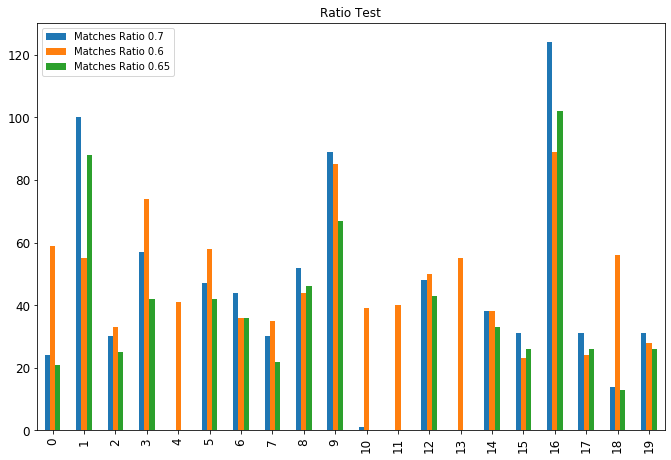

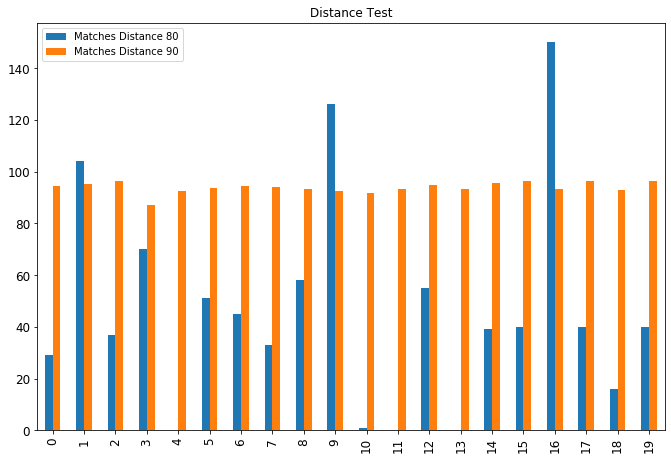

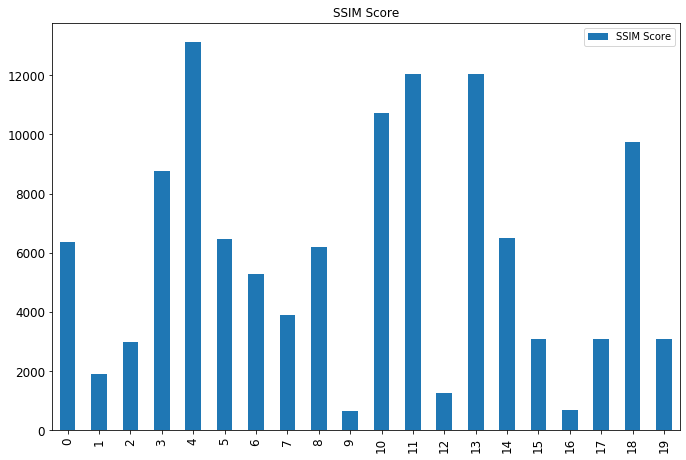

In [27]:
ax = dfx[drop3].plot(kind='bar', title ="Ratio Test", figsize=(11.25, 7.5), legend=True, fontsize=12)
ax = dfx[drop4].plot(kind='bar', title ="Distance Test", figsize=(11.25, 7.5), legend=True, fontsize=12)
ax = dfx[drop5].plot(kind='bar', title ="SSIM Score", figsize=(11.25, 7.5), legend=True, fontsize=12)


plt.show()

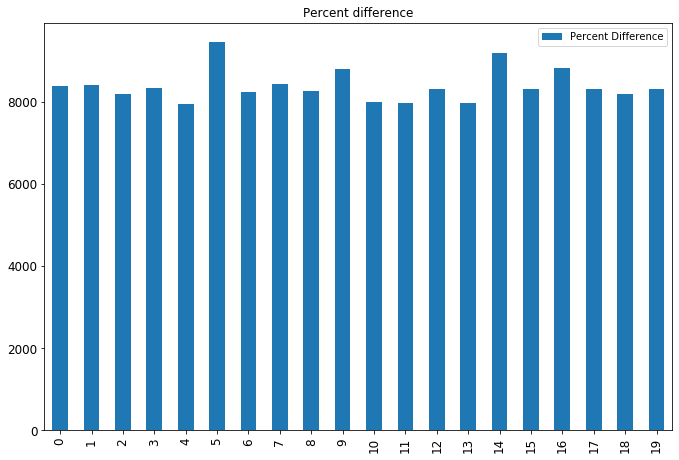

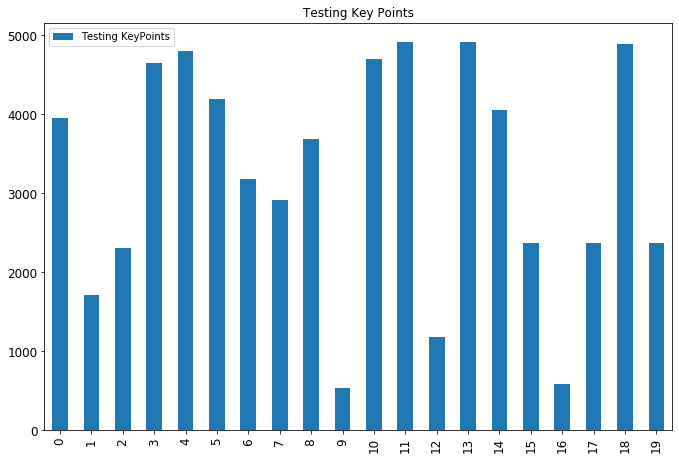

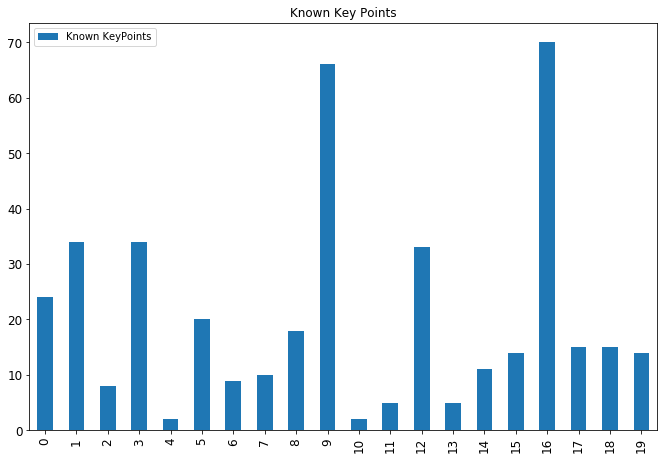

In [28]:
ax = dfx[drop6].plot(kind='bar', title ="Percent difference", figsize=(11.25, 7.5), legend=True, fontsize=12)
ax = dfx[drop7].plot(kind='bar', title ="Testing Key Points", figsize=(11.25, 7.5), legend=True, fontsize=12)
ax = dfx[drop8].plot(kind='bar', title ="Known Key Points", figsize=(11.25, 7.5), legend=True, fontsize=12)

plt.show()

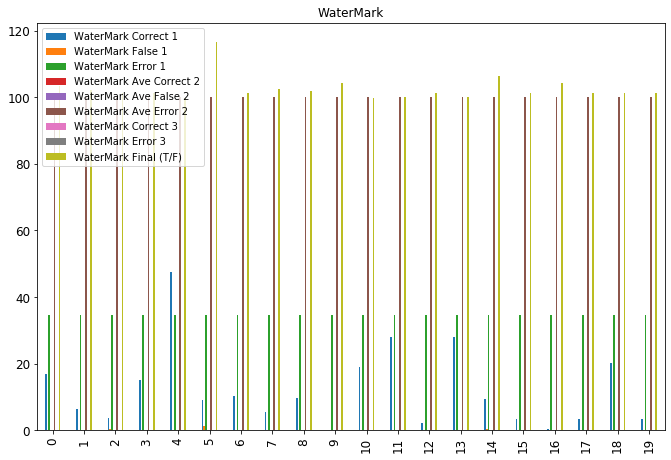

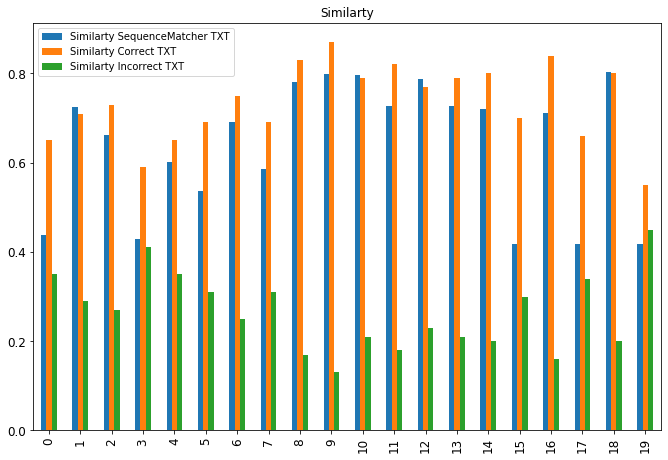

In [29]:
ax = dfx[drop10].plot(kind='bar', title ="WaterMark", figsize=(11.25, 7.5), legend=True, fontsize=12)
ax = dfx[drop11].plot(kind='bar', title ="Similarty", figsize=(11.25, 7.5), legend=True, fontsize=12)

plt.show()

In [30]:
dfx = dfx.drop(drop1, axis = 1)
dfx = dfx.drop(drop2, axis = 1)
dfx = dfx.drop(drop3, axis = 1)
dfx = dfx.drop(drop4, axis = 1)
dfx = dfx.drop(drop5, axis = 1)
dfx = dfx.drop(drop6, axis = 1)
dfx = dfx.drop(drop7, axis = 1)
dfx = dfx.drop(drop8, axis = 1)
dfx = dfx.drop(drop9, axis = 1)
dfx = dfx.drop(drop10, axis = 1)
dfx = dfx.drop(drop11, axis = 1)
dfx

,Title Blue 50,Title Green 50,Title Red 50,Title Blue 80,Title Green 80,Title Red 80,Title Blue 30,Title Green 30,Title Red 30
0,17.853125,17.625000,15.953125,11.793750,11.821875,9.406250,22.237500,21.850000,20.878125
1,15.153125,19.418750,20.746875,8.328125,13.050000,12.853125,19.834375,24.584375,26.712500
2,18.037500,17.368750,20.781250,11.975000,11.590625,13.640625,23.193750,22.231250,26.362500
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,24.112500,23.396875,27.681250,16.121875,15.484375,18.496875,29.521875,28.506250,34.381250
5,31.271875,30.659375,33.221875,26.375000,25.740625,28.637500,34.187500,33.628125,36.153125
6,23.909375,23.271875,26.868750,17.846875,17.215625,20.350000,28.250000,27.409375,31.078125
7,23.290625,23.162500,24.918750,14.190625,14.546875,14.237500,30.162500,29.734375,33.053125
8,21.059375,19.818750,20.046875,14.512500,13.368750,12.246875,25.840625,24.528125,25.337500
9,35.262500,34.753125,31.990625,25.243750,25.350000,20.815625,51.587500,43.996875,49.637500


In [31]:
dfgreentitle = dfx.drop(dropa2, axis = 1)
dfgreentitle = dfgreentitle.drop(dropa3, axis = 1)

dfredtitle = dfx.drop(dropa1, axis = 1)
dfredtitle = dfredtitle.drop(dropa3, axis = 1)

dfbluetitle = dfx.drop(dropa1, axis = 1)
dfbluetitle = dfbluetitle.drop(dropa2, axis = 1)


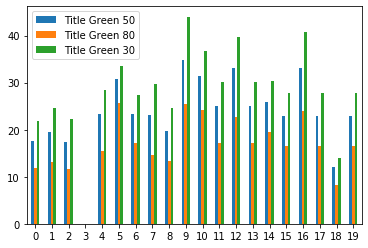

In [32]:
ax = dfgreentitle.plot.bar(rot=0)

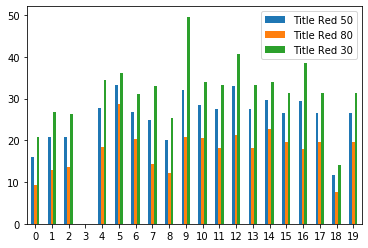

In [33]:
ax = dfredtitle.plot.bar(rot=0)

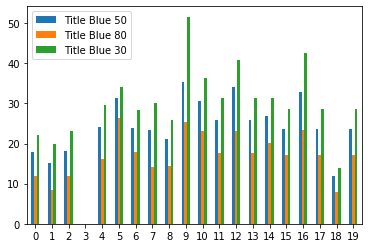

In [34]:
ax = dfbluetitle.plot.bar(rot=0)

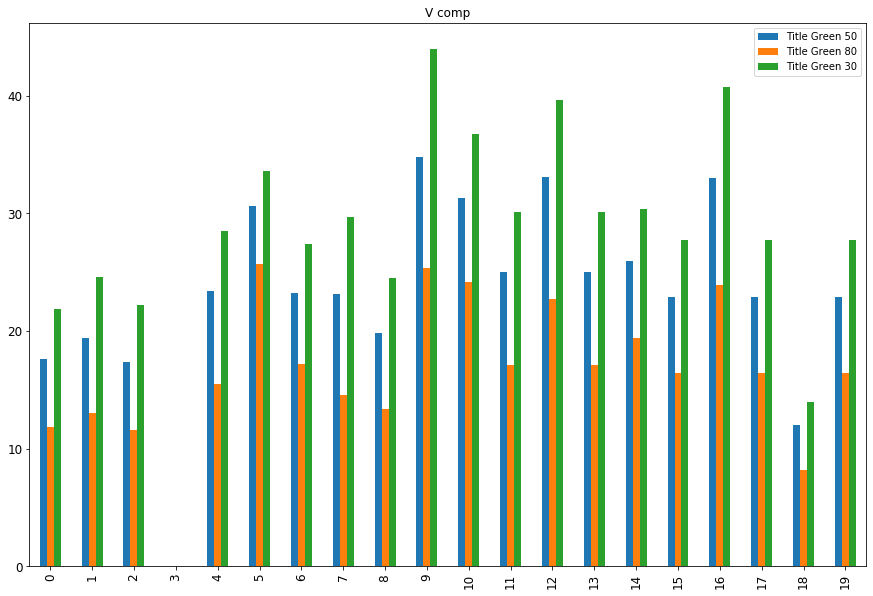

In [35]:
ax = dfx[dropa1].plot(kind='bar', title ="V comp", figsize=(15, 10), legend=True, fontsize=12)

In [36]:
1-5 is real and 6-10 is fake
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/1/1.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/1/1.pdf
78.94736842105263

Document is FAKE

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/10/10.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/10/10.pdf
invalid literal for int() with base 10: ':'
68.42105263157895

Document is FAKE

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/2/2.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/2/2.pdf
42.10526315789473

Document is FAKE

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/3/3.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/3/3.pdf
31.57894736842105

Document is FAKE

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/4/4.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/4/4.pdf
42.10526315789473

Document is FAKE

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/5/5.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/5/5.pdf
78.94736842105263

Document is FAKE

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/6/6.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/6/6.pdf
52.63157894736842

Document is FAKE

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/7/7.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/7/7.pdf
57.89473684210527

Document is FAKE

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/8/8.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/8/8.pdf
73.68421052631578

Document is FAKE

DONE
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/9/9.jpg
/Users/kunal/Documents/VdartWorking/NEWDOCUMENTS/Working/Cut10/TestingFinalBothDir/9/9.pdf
36.84210526315789

Document is FAKE

DONE

SyntaxError: invalid syntax (<ipython-input-36-8ee1474660cc>, line 2)